In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

from inputs import inputs
from model import Model
from capt_gen import capt_gen, capt_decode

In [2]:
from capt_gen import height, width, n_len, n_classes #64, 128, 4, 36
batch_size = 64

epochs = 2
max_step = 1 + 5000#7000
eval_every = 50
output_every = 100
save_every = 1000

output_dir = './output'
if os.path.exists(output_dir):
    tf.gfile.DeleteRecursively(output_dir) #shutil.rmtree(output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [3]:
def _train_inputs(data_dir='./tfrecords/', batch_size=64):
    with tf.variable_scope('train_inputs'):
        images, labels = inputs(data_dir, batch_size=batch_size)
    print(images, labels)
    return  images, labels


def _test_inputs(height=64, width=128, n_len=4):
    with tf.variable_scope('test_inputs'):
        x_ph = tf.placeholder(shape=[None, height, width, 3], dtype=tf.float32, name='x_ph')
        y_ph = tf.placeholder(shape=[None, n_len], dtype=tf.int64, name='y_ph')
        tf.summary.image('images', x_ph)
             
        with tf.variable_scope('preprocessing'):
            images = tf.map_fn(lambda x: tf.image.per_image_standardization(x), x_ph)
    
    print(images, '\n')
    labels = y_ph
    return images, labels, x_ph, y_ph

In [4]:
tf.reset_default_graph()
train_images, train_labels = _train_inputs()
test_images, test_labels, x_ph, y_ph = _test_inputs()

n_convs = 3
n_denses = 1


train_model = Model(images=train_images, labels=train_labels, 
                    n_len=n_len, n_classes=n_classes, 
                    n_convs=n_convs, n_denses=n_denses, training=True)

with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    test_model = Model(images=test_images, labels=test_labels, 
                       n_len=n_len, n_classes=n_classes, 
                       n_convs=n_convs, n_denses=n_denses, training=False)

print('\n\n')

Filling queue with 1600 captcha images before starting to train. This will take a few minutes
Tensor("train_inputs/shuffle_batch:0", shape=(64, 64, 128, 3), dtype=float32) Tensor("train_inputs/Reshape:0", shape=(64, 4), dtype=int64)
Tensor("test_inputs/preprocessing/map/TensorArrayStack/TensorArrayGatherV3:0", shape=(?, 64, 128, 3), dtype=float32) 

_conv_layer	 Tensor("inception3/dropout/mul:0", shape=(64, 8, 16, 32), dtype=float32)
_rnn_layer	 Tensor("bidirectional_rnn/strided_slice:0", shape=(64, 512), dtype=float32)
_output_layer	 Tensor("output/Reshape:0", shape=(64, 4, 36), dtype=float32) 

_conv_layer	 Tensor("inception3_1/concat:0", shape=(?, 8, 16, 32), dtype=float32)
_rnn_layer	 Tensor("bidirectional_rnn_1/strided_slice:0", shape=(?, 512), dtype=float32)
_output_layer	 Tensor("output_1/Reshape:0", shape=(?, 4, 36), dtype=float32) 






In [5]:
saver = tf.train.Saver()
checkpoint_path = os.path.join(output_dir, 'model', 'model.ckpt')

sess = tf.Session()

summary_op = tf.summary.merge_all()
summary_dir = os.path.join(output_dir, 'summary')
summary_writer = tf.summary.FileWriter(summary_dir, sess.graph)

sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

train_loss_vec = []
test_loss_vec = []
acc_vec = []
acc_vec_ = []

capt = capt_gen(batch_size=test_model.batch_size)

In [6]:
for epoch in range(epochs):
    state = sess.run(train_model.init_state)

    for i in range(max_step):
        train_dict = {train_model.init_state[0]: state[0], train_model.init_state[1]: state[1]}
        _, state = sess.run([train_model.train_op, train_model.final_state], feed_dict=train_dict)

        if i % 100 == 0:
            temp_train_loss = sess.run(train_model.eval.loss, feed_dict=train_dict)
            train_loss_vec.append(temp_train_loss)

            
            #test
            tx, ty = next(capt)
            test_state = sess.run(test_model.init_state)
            test_dict = {x_ph: tx, y_ph: ty, 
                        test_model.init_state[0]: test_state[0], test_model.init_state[1]: test_state[1]}
            temp_test_loss, temp_acc, temp_acc_ = sess.run(
                [test_model.eval.loss, test_model.eval.acc, test_model.eval.acc_], feed_dict=test_dict)
            test_loss_vec.append(temp_test_loss)
            acc_vec.append(temp_acc)
            acc_vec_.append(temp_acc_)
            
            summary_str = sess.run(summary_op, feed_dict=test_dict)
            summary_writer.add_summary(summary_str, i + epoch*(max_step-1))

        if i % 100 == 0:
            print('%d/%d' % (i, epoch+1), '\t', 'train_loss: %.4f\t' % temp_train_loss, 'test_loss: %.4f\t' % temp_test_loss, 
                  'acc: %.2f\t' % (temp_acc*100), 'acc_: %.2f\t' % (temp_acc_*100))

        if i % 1000 == 0:
            saver.save(sess, checkpoint_path, global_step=(i + epoch*(max_step-1)))


vec_path = os.path.join(output_dir, 'vec.pkl')
with open(vec_path, 'wb') as f:
    pickle.dump([train_loss_vec, test_loss_vec, acc_vec, acc_vec_], f)

0/1 	 train_loss: 3.6000	 test_loss: 3.5940	 acc: 0.00	 acc_: 3.91	
100/1 	 train_loss: 3.5843	 test_loss: 3.5790	 acc: 0.00	 acc_: 2.34	
200/1 	 train_loss: 3.5848	 test_loss: 3.5826	 acc: 0.00	 acc_: 2.34	
300/1 	 train_loss: 3.5845	 test_loss: 3.5848	 acc: 0.00	 acc_: 3.91	
400/1 	 train_loss: 3.5443	 test_loss: 3.5348	 acc: 0.00	 acc_: 5.47	
500/1 	 train_loss: 2.9794	 test_loss: 2.9130	 acc: 0.00	 acc_: 15.62	
600/1 	 train_loss: 2.4990	 test_loss: 2.2326	 acc: 0.00	 acc_: 31.25	
700/1 	 train_loss: 1.8731	 test_loss: 1.6410	 acc: 6.25	 acc_: 46.09	
800/1 	 train_loss: 1.5825	 test_loss: 1.3204	 acc: 18.75	 acc_: 53.91	
900/1 	 train_loss: 1.2102	 test_loss: 0.8928	 acc: 21.88	 acc_: 67.97	
1000/1 	 train_loss: 1.0465	 test_loss: 0.7101	 acc: 31.25	 acc_: 75.00	
1100/1 	 train_loss: 0.9424	 test_loss: 0.6382	 acc: 34.38	 acc_: 77.34	
1200/1 	 train_loss: 0.8251	 test_loss: 0.4696	 acc: 50.00	 acc_: 84.38	
1300/1 	 train_loss: 0.7005	 test_loss: 0.3967	 acc: 62.50	 acc_: 87.50	
140

4200/2 	 train_loss: 0.0986	 test_loss: 0.0256	 acc: 96.88	 acc_: 99.22	
4300/2 	 train_loss: 0.0939	 test_loss: 0.0261	 acc: 96.88	 acc_: 99.22	
4400/2 	 train_loss: 0.0668	 test_loss: 0.0179	 acc: 100.00	 acc_: 100.00	
4500/2 	 train_loss: 0.0329	 test_loss: 0.0327	 acc: 90.62	 acc_: 97.66	
4600/2 	 train_loss: 0.0950	 test_loss: 0.0240	 acc: 96.88	 acc_: 99.22	
4700/2 	 train_loss: 0.0706	 test_loss: 0.0114	 acc: 100.00	 acc_: 100.00	
4800/2 	 train_loss: 0.0787	 test_loss: 0.0517	 acc: 87.50	 acc_: 96.88	
4900/2 	 train_loss: 0.0636	 test_loss: 0.0305	 acc: 96.88	 acc_: 99.22	
5000/2 	 train_loss: 0.0803	 test_loss: 0.0318	 acc: 93.75	 acc_: 98.44	
5100/2 	 train_loss: 0.0848	 test_loss: 0.0384	 acc: 93.75	 acc_: 98.44	
5200/2 	 train_loss: 0.0384	 test_loss: 0.0468	 acc: 90.62	 acc_: 97.66	
5300/2 	 train_loss: 0.0866	 test_loss: 0.0117	 acc: 96.88	 acc_: 99.22	
5400/2 	 train_loss: 0.0620	 test_loss: 0.0521	 acc: 90.62	 acc_: 97.66	
5500/2 	 train_loss: 0.0664	 test_loss: 0.0306	

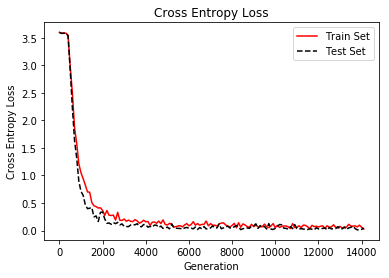

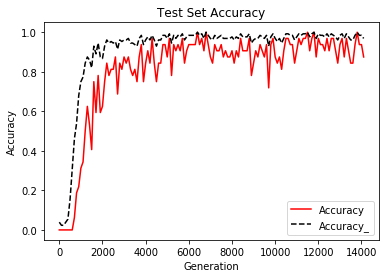

In [7]:
idx = np.arange(0, len(train_loss_vec)*100, 100)

plt.plot(idx, train_loss_vec, 'r-', label='Train Set')
plt.plot(idx, test_loss_vec, 'k--', label='Test Set')
plt.title('Cross Entropy Loss')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.savefig(os.path.join(output_dir, 'loss.png'))
plt.show()

plt.plot(idx, acc_vec, 'r-', label='Accuracy')
plt.plot(idx, acc_vec_, 'k--', label='Accuracy_')
plt.title('Accuracy on Test Set')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig(os.path.join(output_dir, 'accuracy.png'))
plt.show()

acc: 100.00	 acc_: 100.00	 



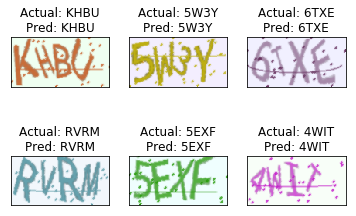

In [8]:
tx, ty = next(capt)
test_state = sess.run(test_model.init_state)
test_dict = {x_ph: tx, y_ph: ty, 
            test_model.init_state[0]: test_state[0], test_model.init_state[1]: test_state[1]}

temp_preds, temp_acc, temp_acc_ = sess.run([test_model.eval.preds, test_model.eval.acc, 
                                           test_model.eval.acc_], feed_dict=test_dict)
print('acc: %.2f\t' % (temp_acc*100), 'acc_: %.2f\t' % (temp_acc_*100), '\n')

n_rows = 2
n_cols = 3
for i in range(n_cols*n_rows):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(tx[i])
    plt.title('Actual: ' + capt_decode(ty[i]) + '\nPred: ' + capt_decode(temp_preds[i]))
    
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.savefig(os.path.join(output_dir, 'sample.png'))
plt.show()